In [1]:
import utils
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import ascii
from scipy import optimize

In [2]:
df_data = utils.read_data("datasets/time-curves/2301590/")

In [3]:
df_time_flux = df_data[['TIME','PDCSAP_FLUX']].dropna()

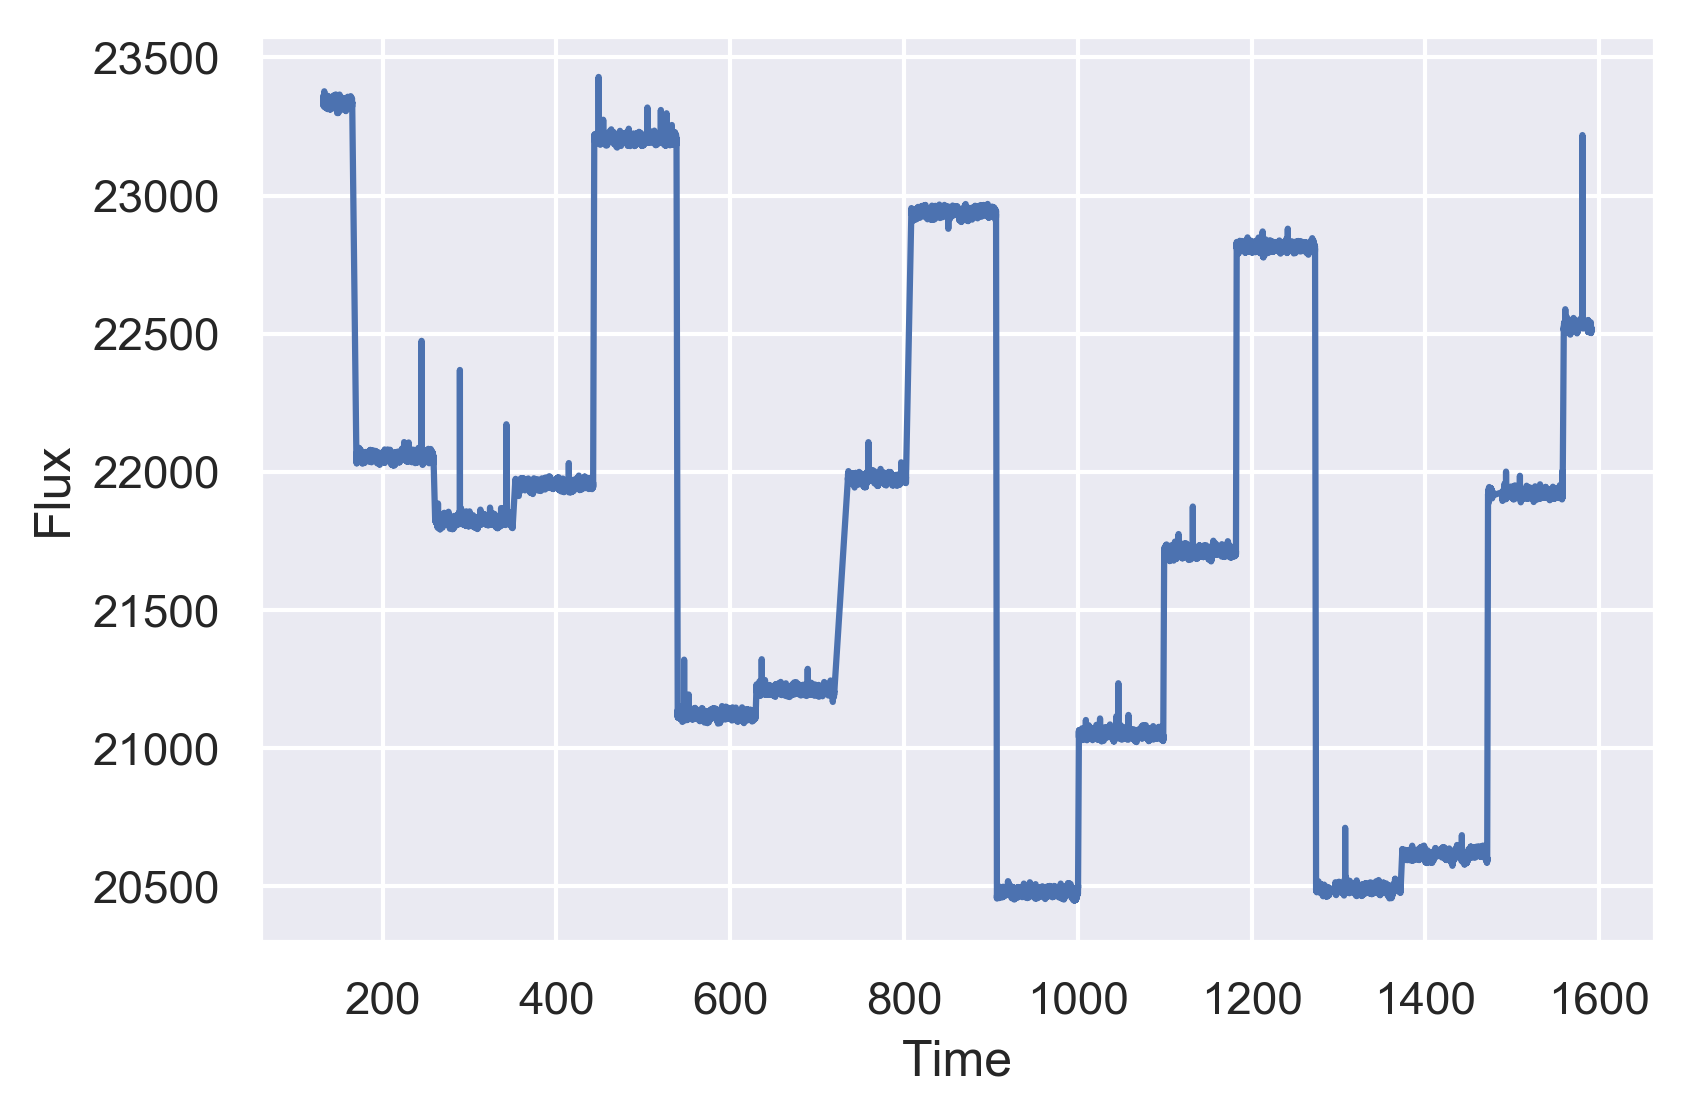

In [4]:
utils.plot_data(df_time_flux.TIME,df_time_flux.PDCSAP_FLUX)

In [5]:
utils.remove_noise(df_time_flux,df_time_flux.PDCSAP_FLUX)

In [6]:
df_reduced = df_time_flux.loc[(df_time_flux.TIME >= 261) & (df_time_flux.TIME <=352)]

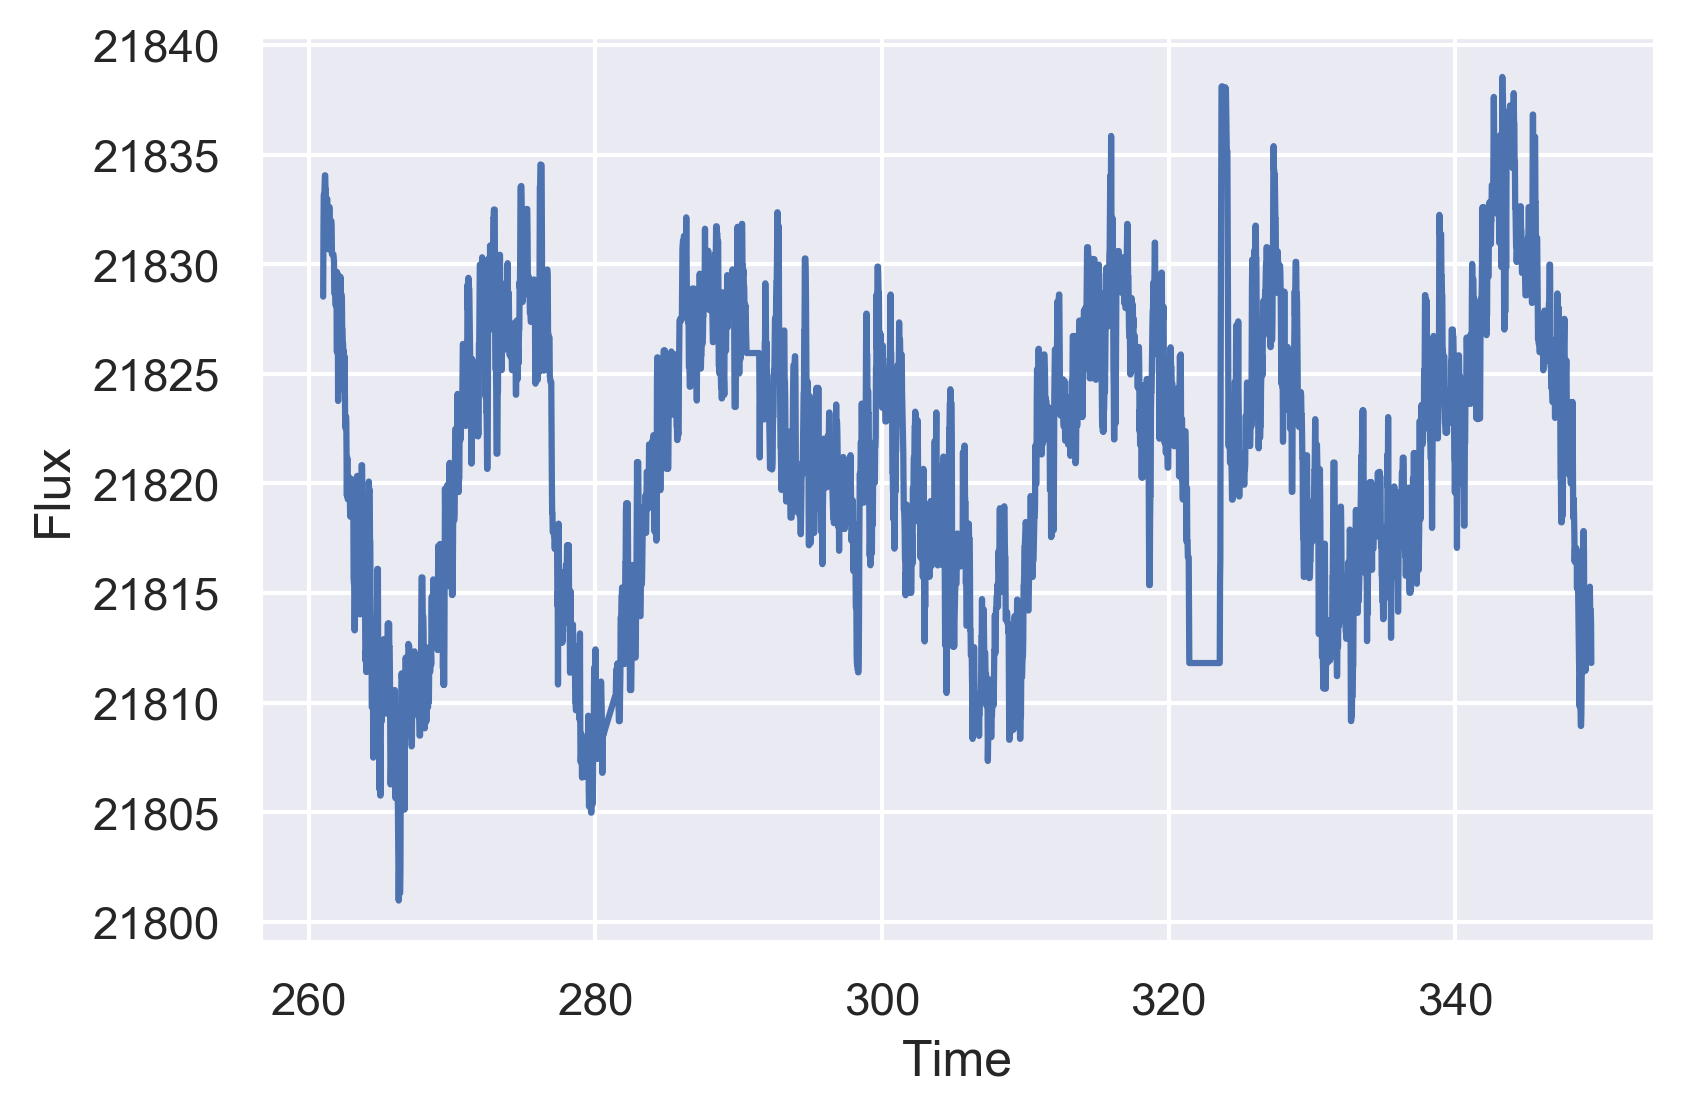

In [7]:
utils.plot_data(df_reduced.TIME,df_reduced.MEDIAN)

### Curve Fitting - Test

In [8]:
tt = df_reduced.TIME
yy = df_reduced.MEDIAN
yynoise = df_reduced.PDCSAP_FLUX
res = utils.fit_sin(df_reduced.TIME, df_reduced.MEDIAN)

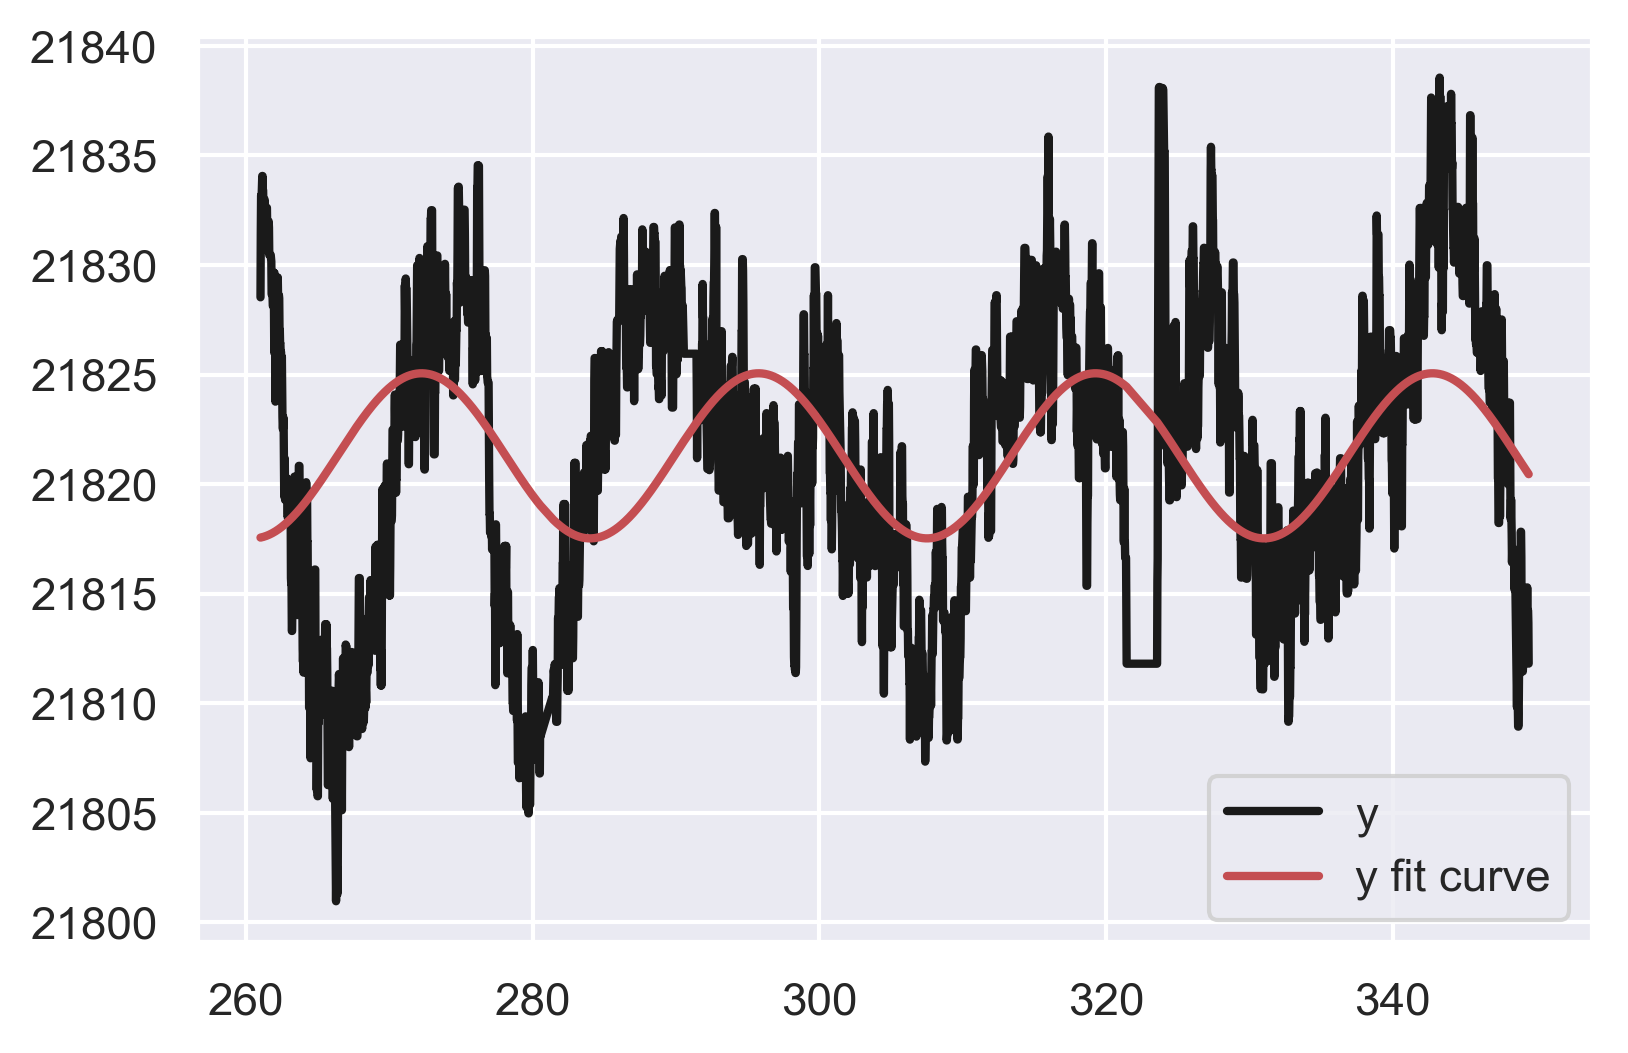

In [9]:
plt.figure(1,dpi=300)
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [10]:
df_reduced = df_time_flux.loc[(df_time_flux.TIME >= 907) & (df_time_flux.TIME <=1001)]

In [11]:
tt = df_reduced.TIME
yy = df_reduced.MEDIAN
yynoise = df_reduced.PDCSAP_FLUX
res = utils.fit_sin(df_reduced.TIME, df_reduced.MEDIAN)

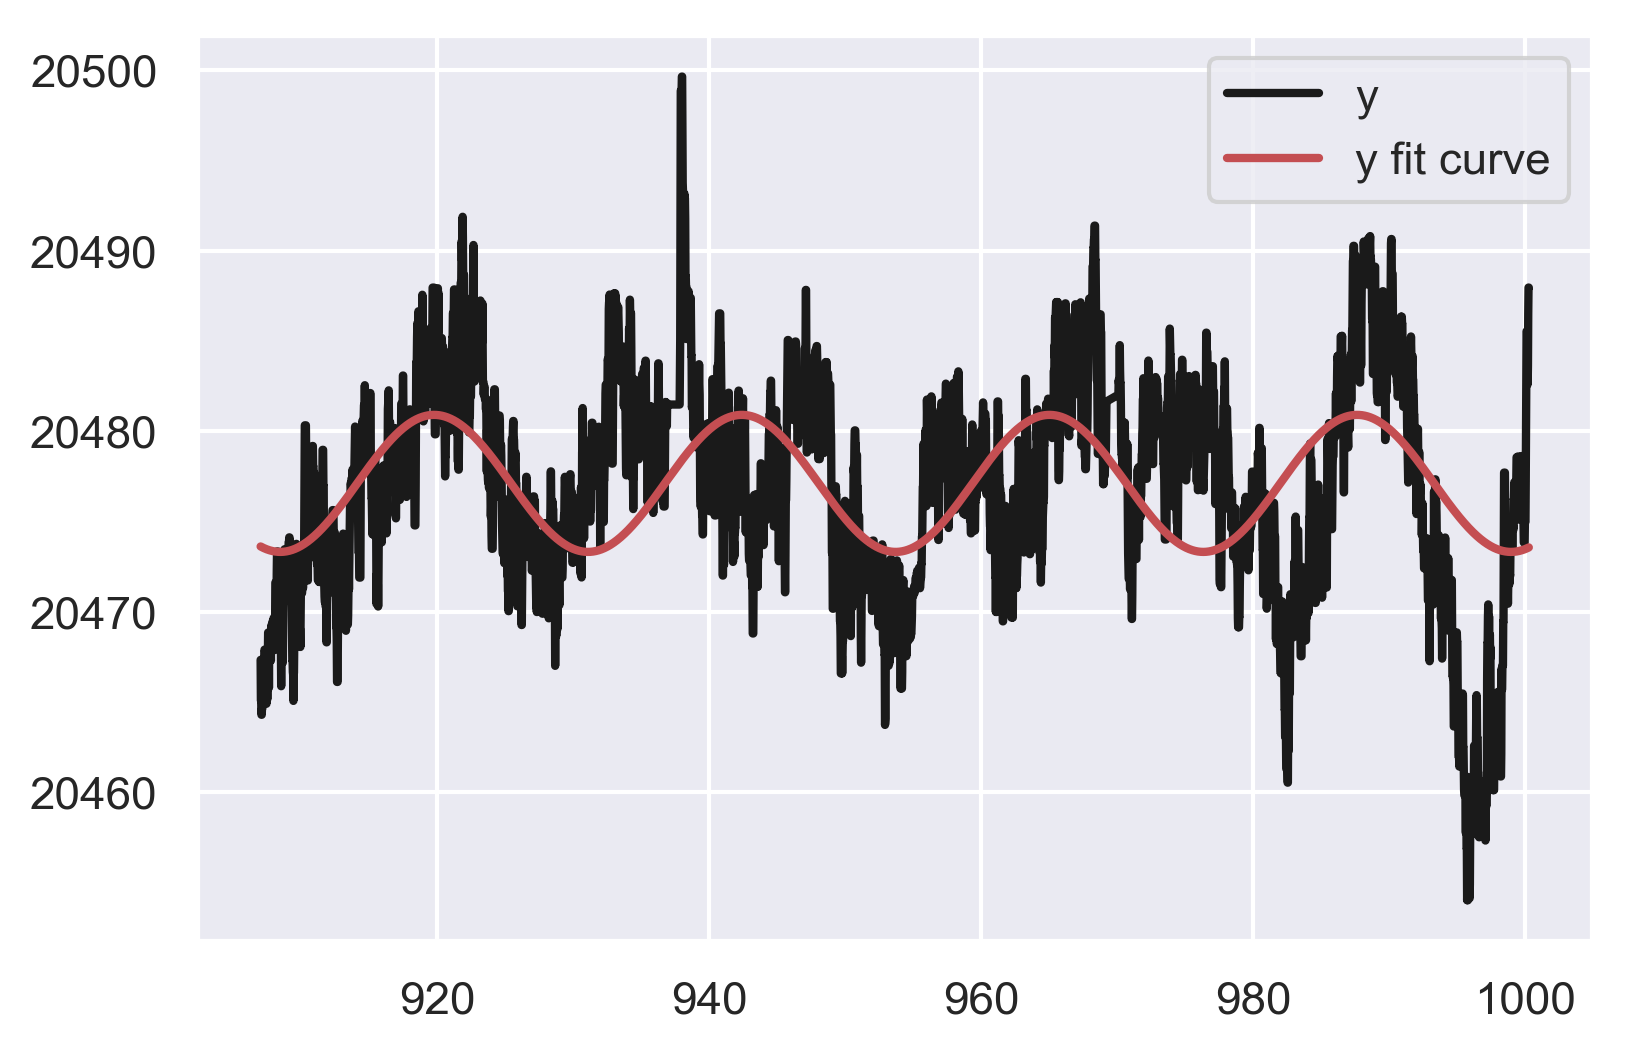

In [12]:
plt.figure(1,dpi=300)
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [13]:
import cProfile

In [15]:
import online_changepoint_detection as oncd
from functools import partial

In [16]:
data = np.array(df_time_flux.MEDIAN.iloc[5000:20000])

In [17]:
R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

C:\Users\Mateus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


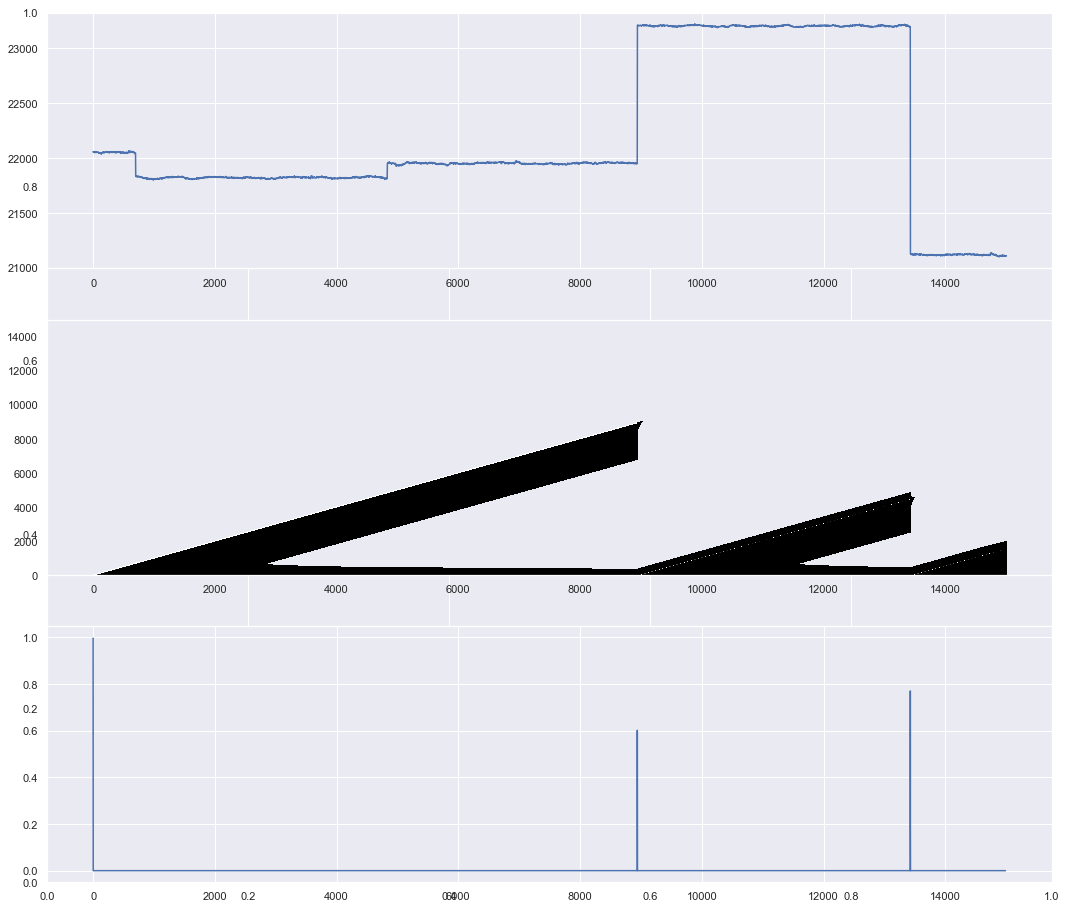

In [18]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])



[[    0  9992  9993 ...  5007  4995 15000]
 [    0  9992  9993 ...  5007  4995 15000]
 [    0  9992  9993 ...  5007  4995 15000]
 ...
 [    0     1  8930 ... 13427  8943     2]
 [    0  8929  8935 ... 13427  8942     1]
 [13029 10013 12795 ... 13357  3128     0]]
